## TextVibCLIP Interactive Inference (UOS & CWRU)

- 새로운 진동 신호 1개를 직접 넣고, 고정된 텍스트 후보들과의 유사도(코사인)를 계산하여 Top‑1을 확인합니다.
- 아래 `RESULTS_DIR`와 `sample_index`만 바꿔가며 바로 검증할 수 있습니다.
- CWRU(4‑클래스)와 UOS(7‑클래스)를 각각 독립 셀로 제공합니다.


In [ ]:
import os
import sys
import torch
import torch.nn.functional as F
import numpy as np
from pathlib import Path

# 프로젝트 루트 경로 추가 (Jupyter 안전)
try:
    PROJECT_ROOT = Path(__file__).resolve().parents[1]
except NameError:
    PROJECT_ROOT = Path.cwd()
    # notebooks/에서 열렸다면 상위로 이동하여 `src` 탐색
    if not (PROJECT_ROOT / 'src').exists():
        if (PROJECT_ROOT.parent / 'src').exists():
            PROJECT_ROOT = PROJECT_ROOT.parent
        elif (PROJECT_ROOT.parent.parent / 'src').exists():
            PROJECT_ROOT = PROJECT_ROOT.parent.parent
sys.path.insert(0, str(PROJECT_ROOT))
print('PROJECT_ROOT =', PROJECT_ROOT)
# 작업 디렉토리를 프로젝트 루트로 강제 설정 (경로 혼동 방지)
import os as _os
try:
    _os.chdir(str(PROJECT_ROOT))
    print('CWD =', Path.cwd())
except Exception as _e:
    print('chdir failed:', _e)

from src.continual_trainer import ContinualTrainer
from src.data_loader import create_domain_dataloaders
from src.utils import normalize_signal, create_windowed_signal
from configs.model_config import DATA_CONFIG, CWRU_DATA_CONFIG

# 공통 유틸
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('DEVICE =', DEVICE)

def load_trainer(dataset_type: str, results_dir: str, scenario_name: str, save_name: str):
    save_dir = f"checkpoints/{scenario_name}"
    results_dir_abs = str((PROJECT_ROOT / results_dir).resolve()) if not os.path.isabs(results_dir) else results_dir
    mirror_dir = os.path.join(results_dir_abs, 'checkpoints', scenario_name)
    # mirror가 있으면 우선 사용
    ckpt_dir = mirror_dir if os.path.isdir(mirror_dir) else save_dir
    data_dir_abs = str((PROJECT_ROOT / ('data_scenario2' if dataset_type=='cwru' else 'data_scenario1')).resolve())
    trainer = ContinualTrainer(device=DEVICE,
                               save_dir=save_dir,
                               domain_order=( [0,1,2,3] if dataset_type=='cwru' else [600,800,1000,1200,1400,1600] ),
                               data_dir=data_dir_abs,
                               dataset_type=dataset_type)
    # 마지막 도메인 best 로드 시도 (존재하면 모델 내부 로더에서 처리한다고 가정하거나, 필요 시 수동 로드 구현)
    print(f"Checkpoint dir: {ckpt_dir}")
    print(f"Data dir: {data_dir_abs}")
    return trainer, ckpt_dir




PROJECT_ROOT = /data/home/kyj2024/TextVibCLIP
CWD = /data/home/kyj2024/TextVibCLIP


/data/home/kyj2024/anaconda3/envs/TVCLIP/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data/home/kyj2024/anaconda3/envs/TVCLIP/lib/python3.8/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/data/home/kyj2024/anaconda3/envs/TVCLIP

DEVICE = cuda


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

COLORS4 = ['#2ca02c', '#1f77b4', '#d62728', '#ff7f0e']
COLORS7 = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2']


def visualize_retrieval(vib_signal: torch.Tensor,
                        prompts: list,
                        sims: torch.Tensor,
                        pred_idx: int,
                        title: str = 'Retrieval Result',
                        true_label: str = None,
                        sample_index: int = None,
                        save_path: str = None):
    """
    vib_signal: (1, W) or (W,) tensor
    prompts: list[str]
    sims: (1, C) tensor
    pred_idx: int
    true_label: optional ground-truth label string for title 표시
    """
    vib_np = vib_signal.detach().cpu().numpy().reshape(-1)
    sims_np = sims.detach().cpu().numpy().reshape(-1)

    num_classes = len(prompts)
    colors = COLORS7 if num_classes >= 7 else COLORS4
    colors = colors[:num_classes]

    fig = plt.figure(figsize=(13, 4.6))
    # 우측(similarity)을 더 크게, 좌측(신호)을 작게
    gs = fig.add_gridspec(1, 2, width_ratios=[0.8, 1.7])

    # Left: Vibration signal (작게)
    ax0 = fig.add_subplot(gs[0, 0])
    ax0.plot(vib_np, color='#34495e', linewidth=0.9)
    ax0.set_title('Vibration signal', fontweight='bold')
    ax0.set_xlabel('Samples')
    ax0.set_ylabel('Amplitude')

    # Right: Similarity bars (크게)
    ax1 = fig.add_subplot(gs[0, 1])
    x = np.arange(num_classes)
    bars = ax1.bar(x, sims_np, color=colors, alpha=0.9, edgecolor='white')
    # highlight predicted
    bars[pred_idx].set_edgecolor('#e74c3c')
    bars[pred_idx].set_linewidth(3)

    ax1.set_xticks(x)
    ax1.set_xticklabels([p[:18] + ('…' if len(p) > 18 else '') for p in prompts], rotation=20, ha='right')
    ax1.set_title('Cosine similarity (Text prototypes)', fontweight='bold')
    # 동적 y-limit: 최대값 기준으로 15~30% 여유만 주기 (bars가 잘 보이게)
    maxy = float(sims_np.max()) if sims_np.size > 0 else 1.0
    ylim_top = max(maxy * 1.25, maxy + 0.02)
    ylim_top = max(0.2, ylim_top)
    ax1.set_ylim(0, ylim_top)

    for i, b in enumerate(bars):
        ax1.text(b.get_x()+b.get_width()/2, b.get_height()+ylim_top*0.02, f"{sims_np[i]:.3f}",
                 ha='center', va='bottom', fontsize=9)

    # 우측 끝에 전체 프롬프트 텍스트 표기 (작은 폰트)
    full_text = "\n".join([f"[{i}] {t}" for i, t in enumerate(prompts)])
    ax1.text(1.02, 0.5, full_text, transform=ax1.transAxes, va='center', ha='left', fontsize=9)

    # 제목 구성: GT/Top1 + (optional) sample index
    title_line = f"{title} | Top-1: {prompts[pred_idx]}"
    if true_label is not None:
        title_line = f"{title} | GT: {true_label} | Top-1: {prompts[pred_idx]}"
    if sample_index is not None:
        title_line += f" | sample #{sample_index}"

    fig.suptitle(title_line, fontsize=14, fontweight='bold')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=220, bbox_inches='tight')
    plt.show()



In [3]:
# CWRU: 4-class retrieval inference
RESULTS_DIR = 'results/v2_20251001_022253'
SCENARIO = 'CWRU_Scenario2_VaryingLoad_v2'
DOMAIN = 3  # 0,1,2,3 중 선택
subset = 'test'  # 'val'도 가능
sample_index = 111 # 여러 샘플로 바꿔가며 확인
sample_index = 110 # 여러 샘플로 바꿔가며 확인

Checkpoint dir: checkpoints_v2/CWRU_Scenario2_VaryingLoad_v2
Data dir: /data/home/kyj2024/TextVibCLIP/data_scenario2
CWRU Domain 3 (test) dataset size = 112 | sample_index ∈ [0, 111]


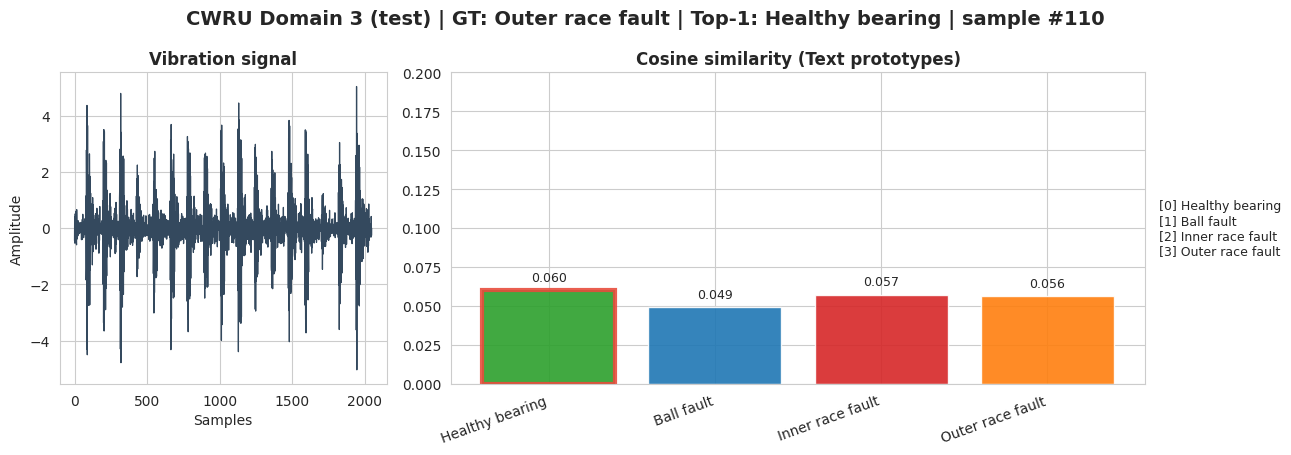

In [4]:
trainer, ckpt_dir = load_trainer('cwru', RESULTS_DIR, SCENARIO, 'domain_3_best_v2.pth')

# 도메인별 dataloader 준비 (현재 결과와 동일 split)
loaders = create_domain_dataloaders(data_dir='data_scenario2', domain_order=[0,1,2,3], dataset_type='cwru', batch_size=64)
loader = loaders[DOMAIN][subset]

# 데이터셋 전역 인덱스로 샘플 선택 (배치가 아닌 전체 데이터 기준)
dataset = loader.dataset
print(f"CWRU Domain {DOMAIN} ({subset}) dataset size = {len(dataset)} | sample_index ∈ [0, {len(dataset)-1}]")
gidx = sample_index % len(dataset)
sample = dataset[gidx]

vib = sample['vibration'].unsqueeze(0).to(DEVICE)
labels = sample['labels'].unsqueeze(0).to(DEVICE)
idx = gidx

# 텍스트 프롬프트(프로토타입)
prompt_bank = {
    0: ["healthy bearing", "normal bearing with no fault", "bearing vibration without defect"],
    1: ["bearing with ball fault", "ball defect in bearing", "ball damage on bearing"],
    2: ["bearing inner race fault", "inner ring defect in bearing", "inner race damage of bearing"],
    3: ["bearing outer race fault", "outer ring defect in bearing", "outer race damage of bearing"],
}
texts = sum(prompt_bank.values(), [])  # flatten

trainer.model.eval()
with torch.no_grad():
    # 진동 임베딩
    vib_raw = trainer.model.vib_encoder(vib)
    vib_emb = F.normalize(trainer.model.vib_projection(vib_raw), p=2, dim=1)
    # 텍스트 임베딩(프로토타입 평균)
    proto = []
    for cls_id in [0,1,2,3]:
        raw = trainer.model.text_encoder.encode_texts(prompt_bank[cls_id], DEVICE)
        proj = F.normalize(trainer.model.text_projection(raw), p=2, dim=1)
        proto.append(F.normalize(proj.mean(dim=0, keepdim=True), p=2, dim=1))
    proto_mat = torch.cat(proto, dim=0)
    sims = vib_emb @ proto_mat.t()
    pred = sims.argmax(dim=1).item()

prompts = ["Healthy bearing","Ball fault","Inner race fault","Outer race fault"]
gt = ["Healthy bearing","Ball fault","Inner race fault","Outer race fault"][labels.squeeze().item()]
visualize_retrieval(vib_signal=vib,
                    prompts=prompts,
                    sims=sims,
                    pred_idx=pred,
                    title=f"CWRU Domain {DOMAIN} ({subset})",
                    true_label=gt,
                    sample_index=idx)


In [5]:
# UOS: 7-class retrieval inference
RESULTS_DIR = 'results/v2_20251001_022253'
SCENARIO = 'UOS_Scenario1_VaryingSpeed_v2'
DOMAIN_RPM = 600  # 600,800,1000,1200,1400,1600
subset = 'test'
sample_index = 1232  # sample_index ∈ [0, 1749]

Checkpoint dir: checkpoints_v2/UOS_Scenario1_VaryingSpeed_v2
Data dir: /data/home/kyj2024/TextVibCLIP/data_scenario1
UOS 600RPM (test) dataset size = 1750 | sample_index ∈ [0, 1749]


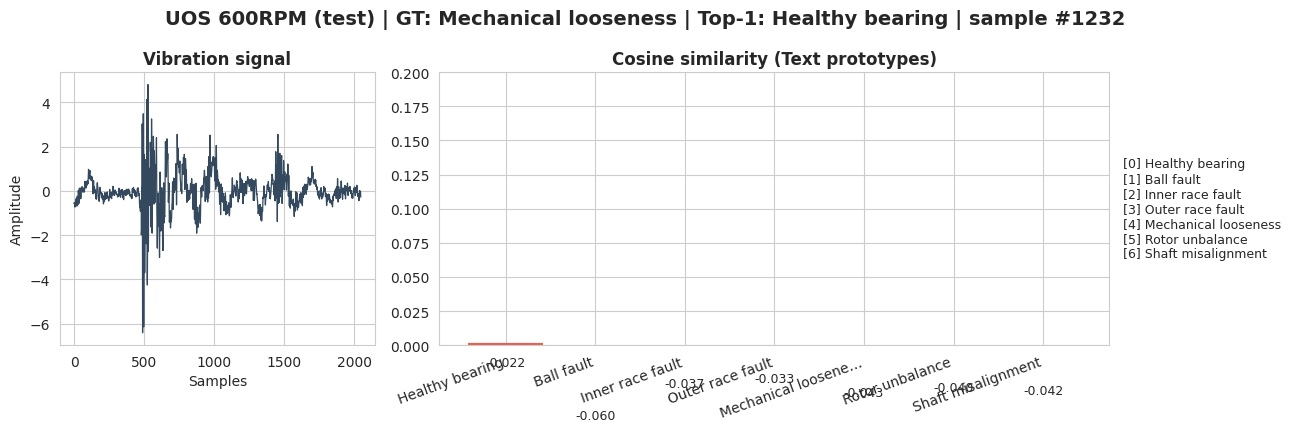

In [6]:

trainer, ckpt_dir = load_trainer('uos', RESULTS_DIR, SCENARIO, f'domain_{DOMAIN_RPM}_best_v2.pth')

loaders = create_domain_dataloaders(data_dir='data_scenario1', domain_order=[600,800,1000,1200,1400,1600], dataset_type='uos', batch_size=64)
loader = loaders[DOMAIN_RPM][subset]

# 데이터셋 전역 인덱스로 샘플 선택 (배치가 아닌 전체 데이터 기준)
dataset = loader.dataset
print(f"UOS {DOMAIN_RPM}RPM ({subset}) dataset size = {len(dataset)} | sample_index ∈ [0, {len(dataset)-1}]")
gidx = sample_index % len(dataset)
sample = dataset[gidx]

vib = sample['vibration'].unsqueeze(0).to(DEVICE)
labels_uos = sample['labels'].unsqueeze(0)  # [1,2] 구조일 수 있음
idx = gidx

# 7-클래스 프롬프트
prompt_bank = {
    0: ["healthy bearing"],          # H_H
    1: ["bearing with ball fault"],  # H_B
    2: ["inner race fault"],         # H_IR
    3: ["outer race fault"],         # H_OR
    4: ["mechanical looseness"],     # L_H
    5: ["rotor unbalance"],          # U_H
    6: ["shaft misalignment"],       # M_H
}

trainer.model.eval()
with torch.no_grad():
    vib_raw = trainer.model.vib_encoder(vib)
    vib_emb = F.normalize(trainer.model.vib_projection(vib_raw), p=2, dim=1)
    proto = []
    for cls_id in [0,1,2,3,4,5,6]:
        raw = trainer.model.text_encoder.encode_texts(prompt_bank[cls_id], DEVICE)
        proj = F.normalize(trainer.model.text_projection(raw), p=2, dim=1)
        proto.append(F.normalize(proj.mean(dim=0, keepdim=True), p=2, dim=1))
    proto_mat = torch.cat(proto, dim=0)
    sims = vib_emb @ proto_mat.t()
    pred = sims.argmax(dim=1).item()

prompts7 = [
    "Healthy bearing", "Ball fault", "Inner race fault", "Outer race fault",
    "Mechanical looseness", "Rotor unbalance", "Shaft misalignment"
]
# UOS GT 라벨(7-클래스) 추출: labels[:,0]가 메인 라벨
try:
    gt_idx = int(labels_uos[0, 0].item())
    gt_text = prompts7[gt_idx] if 0 <= gt_idx < len(prompts7) else None
except Exception:
    gt_text = None

visualize_retrieval(vib_signal=vib,
                    prompts=prompts7,
                    sims=sims,
                    pred_idx=pred,
                    title=f"UOS {DOMAIN_RPM}RPM ({subset})",
                    true_label=gt_text,
                    sample_index=idx)
